In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from urllib.request import urlopen
from PIL import Image


from tqdm import tqdm
import string
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig


# Plotly based imports for visualization
import plotly.express as px
data = px.data.gapminder()
from plotly.subplots import make_subplots
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff


from nltk.corpus import stopwords
from nltk.util import ngrams
import nltk
stop=stopwords.words('english')

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
nlp = spacy.load("en_core_web_lg")
import pytextrank
tr = pytextrank.TextRank()
nlp.add_pipe(tr.PipelineComponent, name='textrank', last=True)
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\ProgramData\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


C:\ProgramData\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly

C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



In [2]:
df = pd.read_csv('Paatal Lok IMDB Review.csv')
df['string_Rating'] = df.Rating.apply(lambda x: "Rating " + str(x))
df.sample(5)

,Rating,Helpfullness,Review Title,Reviewer Name,Review Date,Review Text,string_Rating
1123,9,0 out of 2 found this helpful,Your past shapes you present,alifarazpbh,23 May 2020,It's well written and directed show which such...,Rating 9
55,10,13 out of 26 found this helpful,Excellent show,amitbala-56541,17 May 2020,Perfect show with perfect story. Must watch. A...,Rating 10
772,10,1 out of 1 found this helpful,Real,ajashere-75565,24 May 2020,One of the finest series ever made. Depicts th...,Rating 10
373,10,6 out of 11 found this helpful,Excellent plot .,raemasen,18 May 2020,Story is tightly webbed and the way many preco...,Rating 10
688,9,3 out of 5 found this helpful,Much needed boost to Indian web series,roychowdhuryaue,18 May 2020,The best thing is the characters are so detail...,Rating 9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 7 columns):
Rating           1149 non-null int64
Helpfullness     1149 non-null object
Review Title     1149 non-null object
Reviewer Name    1149 non-null object
Review Date      1149 non-null object
Review Text      1149 non-null object
string_Rating    1149 non-null object
dtypes: int64(1), object(6)
memory usage: 63.0+ KB


In [4]:
rating_dist = df.groupby(['string_Rating']).size().reset_index(name = 'Number Of Ratings')
rating_dist['Rating Percentage'] = (rating_dist['Number Of Ratings']/df.shape[0])*100

fig = px.bar(rating_dist, x ='string_Rating', y = 'Rating Percentage',
              title= 'User Rating Distribution',
             color = 'Rating Percentage',
             
             height=400, width=800) #color = 'Rating Percentage'
fig.show()

In [5]:
#Mean of word length distribution
#x1 = df[df['Rating']==1]['Review Text'].str.split().apply(lambda x : [len(i) for i in x])
#x1 = x1.map(lambda x: np.mean(x))
#fig = go.Figure(data=[go.Histogram(x=x1)])
#fig.show()

In [6]:
df['Review Length'] = df['Review Text'].str.split().apply(lambda x: len(x))
fig = px.box(df, x="Rating", y="Review Length", title="Review Lengths")
fig.show()

In [7]:
review_length = df.groupby(['Rating']).agg({'Review Length' : {"Mean" : 'mean', "Median" : np.median, "Max":'max', "Min":'min'}})
review_length.columns = review_length.columns.droplevel(0)
review_length = review_length.reset_index()

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=review_length['Rating'], y=review_length['Mean'],
                    mode='lines+markers',
                    name='Mean'))
fig.add_trace(go.Scatter(x=review_length['Rating'], y=review_length['Median'],
                    mode='lines+markers',
                    name='Median'))
fig.add_trace(go.Scatter(x=review_length['Rating'], y=review_length['Max'],
                    mode='lines+markers',
                    name='Max'))
fig.add_trace(go.Scatter(x=review_length['Rating'], y=review_length['Min'],
                    mode='lines+markers',
                    name='Min'))
fig.update_layout(title="Reviews Length Distribution",
    xaxis_title="Rating",
    yaxis_title="Number of Words")
fig.show()

In [9]:
import plotly.graph_objects as go
animals=['giraffes', 'orangutans', 'monkeys']

fig = go.Figure(data=[
    go.Bar(name='Mean', x=review_length['Rating'], y=review_length['Mean']),
    go.Bar(name='Median', x=review_length['Rating'], y=review_length['Median']),
    go.Bar(name='Minimum', x=review_length['Rating'], y=review_length['Min'],marker_color='rgb(55, 83, 109)'),
    go.Bar(name='Maximum', x=review_length['Rating'], y=review_length['Max'],marker_color='rgb(26, 118, 255)')
])
# Change the bar mode
fig.update_layout(barmode='group', title="Reviews Length Distribution",
    xaxis_title="Rating",
    yaxis_title="Number of Words")
fig.show()

In [10]:
#https://help.imdb.com/article/imdb/track-movies-tv/what-does-it-mean-if-i-found-a-user-review-helpful-or-not/G4YY5P5XP2KJ349M?ref_=helpart_nav_16#
def helpfull_percenage(helpfull):
    a = helpfull.strip('found this helpful').split(" ")
    st = int(a[0])
    ed = int(''.join(a[-1:]))
    try:
        return (st/ed)*100
    except:
        return 0

Helpfull_Percentage = df.Helpfullness.apply(helpfull_percenage)
df.insert(loc=2, column='Helpfull Percentage', value=Helpfull_Percentage)

In [11]:
df.head()

,Rating,Helpfullness,Helpfull Percentage,Review Title,Reviewer Name,Review Date,Review Text,string_Rating,Review Length
0,10,495 out of 992 found this helpful,49.899194,One of the finest TV series coming from India.,authentic_writer,15 May 2020,I was hooked to it from the very first episode...,Rating 10,55
1,10,73 out of 140 found this helpful,52.142857,Superb acting with superb script and direction...,saurabhsharma-63079,17 May 2020,This movie revolves around a inspector who is ...,Rating 10,123
2,10,368 out of 785 found this helpful,46.878981,Fantastic,ansegal,15 May 2020,Spell bound I was and for a change the police ...,Rating 10,76
3,10,298 out of 642 found this helpful,46.417445,One of finest of 2020,aspnishanth-81860,15 May 2020,When u start watch it...you will binge watch i...,Rating 10,21
4,10,53 out of 102 found this helpful,51.960784,Rating A+ Not the usual Good versus Evil,ankurchakraborty-83075,19 May 2020,I'm not much into those series whose seasons o...,Rating 10,761


In [12]:
avg_helpfull_percentage_by_rating = df.groupby(['Rating']).agg({'Helpfull Percentage':'mean','Review Length':'mean'}).reset_index()

In [13]:
fig = px.bar(avg_helpfull_percentage_by_rating, x='Rating', y='Helpfull Percentage',orientation='v',
              title= 'Mean Of Helpfull Percentage By Rating',
             labels = {'Rating':'Ratings'},
             height=400, width = 700) #color = 'Helpfull Percentage',
fig.show()

In [14]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=avg_helpfull_percentage_by_rating['Rating'],
        y=avg_helpfull_percentage_by_rating['Helpfull Percentage'],
        name = "Helpfull Percentage"
    ))

fig.add_trace(
    go.Scatter(
        x=avg_helpfull_percentage_by_rating['Rating'],
        y=avg_helpfull_percentage_by_rating['Review Length'],
        name = "Review Length"
    ))
fig.update_layout(title="Reviews Length Distribution",
    xaxis_title="Rating",
    yaxis_title="Helpfull Percentage",
                 yaxis={'categoryorder':'total descending'})
fig.show()

In [15]:
fig = px.scatter_3d(avg_helpfull_percentage_by_rating, x='Rating', y='Helpfull Percentage', z='Review Length')
fig.show()

In [16]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [17]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [18]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [19]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [20]:
def clean_text(text):
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

In [21]:
def remove_stop_words(text):
    return [word for word in text if word not in stop]

In [22]:
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except : # the word "oed" broke this, so needed try except
        pass
    return " ".join(text)

In [23]:
df['Cleaned Text'] = df['Review Text'].apply(remove_URL).apply(remove_html).apply(remove_emoji).\
                        apply(remove_punct).apply(clean_text).apply(remove_stop_words).apply(stem_words)

In [24]:
df['Review Text'].apply(remove_URL).apply(remove_html).apply(remove_emoji).\
                        apply(remove_punct).apply(clean_text).apply(remove_stop_words).apply(stem_words)[0]

'hooked first episode main character true representation everyday man flawed yet tenacious characters intricately put together pacing absolutely perfect absolute gem needs experienced absolutely loved wait season'

In [25]:
df['Title Cleaned Text'] = df['Review Title'].apply(remove_URL).apply(remove_html).apply(remove_emoji).\
                        apply(remove_punct).apply(clean_text).apply(remove_stop_words).apply(stem_words)

In [26]:
def most_common_words(df,col_name,rating,word_num=10):
    review_title_rating = []
    for title in df[col_name][df['Rating'] == rating]:
        review_title_rating.extend(title.split())
    review_title_rating = [title.lower() for title in review_title_rating if title not in spacy.lang.en.stop_words.STOP_WORDS]
    review_title_rating = Counter(review_title_rating)
    most_common_words = review_title_rating.most_common(word_num)
    words = pd.DataFrame(most_common_words, columns=['Words', 'Count'])
    return words

In [27]:
review_title_rating_10 = most_common_words(df,'Title Cleaned Text',10)
review_title_rating_1 = most_common_words(df,'Title Cleaned Text',1)

In [28]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Rating 10", "Rating 1"))
fig.add_trace(go.Bar(x=review_title_rating_10['Words'], y=review_title_rating_10['Count']),
              row=1, col=1)
fig.add_trace(go.Bar(x=review_title_rating_1['Words'], y=review_title_rating_1['Count']),
              row=1, col=2)

fig.update_layout(height=400, width=1000,showlegend=False,
                  xaxis_title="Most Occurance Words in Review Title",
    yaxis_title="Number of Occurance", title={
        'text': "Top 10 words on Review Ttitle",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
                 )

fig.show()

# Ngram analysis
we will do a bigram (n=2) analysis over the tweets.Let's check the most common bigrams in tweets.

In [29]:
def get_top_review_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_bigram = pd.DataFrame(words_freq, columns=('Bigram', 'Counts'))
    return top_bigram.head(n)

In [80]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Rating 1", "Rating 2", "Rating 9", "Rating 10"))

rating_1 = get_top_review_bigrams(df['Cleaned Text'][df['Rating'] ==1], 10)
fig.add_trace(go.Bar(x=rating_1['Bigram'], y=rating_1['Counts']),
              row=1, col=1)

rating_2 = get_top_review_bigrams(df['Cleaned Text'][df['Rating'] ==2], 10)
fig.add_trace(go.Bar(x=rating_2['Bigram'], y=rating_2['Counts']),
              row=1, col=2)

rating_9 = get_top_review_bigrams(df['Cleaned Text'][df['Rating'] ==9], 10)
fig.add_trace(go.Bar(x=rating_9['Bigram'], y=rating_9['Counts']),
              row=2, col=1)

rating_10 = get_top_review_bigrams(df['Cleaned Text'][df['Rating'] ==10], 10)
fig.add_trace(go.Bar(x=rating_10['Bigram'], y=rating_10['Counts']),
              row=2, col=2)

# edit axis labels
fig['layout']['xaxis']['title']='Top 10 bi-gram in Rating Star 1'
fig['layout']['xaxis2']['title']='Top 10 bi-gram in Rating Star 2'
fig['layout']['xaxis3']['title']='Top 10 bi-gram in Rating Star 9'
fig['layout']['xaxis4']['title']='Top 10 bi-gram in Rating Star 10'
fig['layout']['yaxis']['title']='Number Of Occurance'
fig['layout']['yaxis2']['title']='Number Of Occurance'
fig['layout']['yaxis']['title']='Number Of Occurance'
fig['layout']['yaxis2']['title']='Number Of Occurance'

fig.update_layout(height=800, width=1000,showlegend=False,title={
        'text': "Top 10 bi-gram on Review Text"},
                 )

fig.show()

In [78]:
def get_top_review_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_bigram = pd.DataFrame(words_freq, columns=('Bigram', 'Counts'))
    return top_bigram.head(n)

In [79]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Rating 1", "Rating 2", "Rating 9", "Rating 10"))

rating_1 = get_top_review_trigrams(df['Cleaned Text'][df['Rating'] ==1], 10)
fig.add_trace(go.Bar(x=rating_1['Bigram'], y=rating_1['Counts']),
              row=1, col=1)

rating_2 = get_top_review_trigrams(df['Cleaned Text'][df['Rating'] ==2], 10)
fig.add_trace(go.Bar(x=rating_2['Bigram'], y=rating_2['Counts']),
              row=1, col=2)

rating_9 = get_top_review_trigrams(df['Cleaned Text'][df['Rating'] ==9], 10)
fig.add_trace(go.Bar(x=rating_9['Bigram'], y=rating_9['Counts']),
              row=2, col=1)

rating_10 = get_top_review_trigrams(df['Cleaned Text'][df['Rating'] ==10], 10)
fig.add_trace(go.Bar(x=rating_10['Bigram'], y=rating_10['Counts']),
              row=2, col=2)

# edit axis labels
fig['layout']['xaxis']['title']='Top 10 trigram in Rating Star 1'
fig['layout']['xaxis2']['title']='Top 10 trigram in Rating Star 2'
fig['layout']['xaxis3']['title']='Top 10 trigram in Rating Star 9'
fig['layout']['xaxis4']['title']='Top 10 trigram in Rating Star 10'
fig['layout']['yaxis']['title']='Number Of Occurance'
fig['layout']['yaxis2']['title']='Number Of Occurance'
fig['layout']['yaxis']['title']='Number Of Occurance'
fig['layout']['yaxis2']['title']='Number Of Occurance'

fig.update_layout(height=800, width=1000,showlegend=False,title={
        'text': "Top 10 tri-gram on Review Text"},
                 )

fig.show()

In [31]:
def textrank(review):
    doc = nlp(review)
    last_index = len(doc._.phrases)
    if last_index > 5:
        last_index = 5
    ranked_words = []    
    for p in doc._.phrases[0:last_index]:
        ranked_words.append(p)
    #ranked_words = ranked_words  
    return ranked_words

In [32]:
df['Review Text Rank'] = df['Cleaned Text'].apply(textrank)

In [33]:
Review_Text = df['Review Text'][df['Rating'] == 1].sample().reset_index()['Review Text'][0]
print(Review_Text)
textrank(Review_Text)

It took me 3 days to complete this series due to its same old concept storyline where a suspended cop carry out the investigation alone and more thn smart thn whole CBI team. unnecessary Hindu bashing series where Hindu people shown as most cruel and responsible for Muslim to become terrorist but Director is not aware about terrorism outside India where there is no Hindu population , unnecessary rape and sexual scene which was also not required at all. Over All bad series ..not recommended


[unnecessary hindu bashing series,
 unnecessary rape,
 hindu people,
 sexual scene,
 its same old concept storyline]

In [34]:
# examine the top-ranked phrases in the document
doc = nlp(Review_Text)
for p in doc._.phrases:
    print('{:.4f} {:5d}  {}'.format(p.rank, p.count, p.text))
    print(p.chunks)

0.1610     1  unnecessary hindu bashing series
[unnecessary Hindu bashing series]
0.1222     1  unnecessary rape
[unnecessary rape]
0.1160     1  hindu people
[Hindu people]
0.0874     1  sexual scene
[sexual scene]
0.0844     1  its same old concept storyline
[its same old concept storyline]
0.0829     1  director
[Director]
0.0807     2  muslim
[Muslim, Muslim]
0.0784     1  terrorism
[terrorism]
0.0722     1  cbi
[CBI]
0.0683     1  all bad series
[All bad series]
0.0617     1  this series
[this series]
0.0606     1  hindu
[Hindu]
0.0590     2  india
[India, India]
0.0579     1  a suspended cop
[a suspended cop]
0.0511     1  no hindu population
[no Hindu population]
0.0399     2  3 days
[3 days, 3 days]
0.0288     1  the investigation
[the investigation]
0.0000     3  it
[It, me, which]


In [35]:
def increment_edge (graph, node0, node1):
    #print("link {} {}".format(node0, node1))
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

In [36]:
POS_KEPT = ["ADJ", "NOUN", "PROPN", "VERB"]

def link_sentence (doc, sent, lemma_graph, seen_lemma):
    visited_tokens = []
    visited_nodes = []

    for i in range(sent.start, sent.end):
        token = doc[i]

        if token.pos_ in POS_KEPT:
            key = (token.lemma_, token.pos_)

            if key not in seen_lemma:
                seen_lemma[key] = set([token.i])
            else:
                seen_lemma[key].add(token.i)

            node_id = list(seen_lemma.keys()).index(key)

            if not node_id in lemma_graph:
                lemma_graph.add_node(node_id)

            #print("visit {} {}".format(visited_tokens, visited_nodes))
            #print("range {}".format(list(range(len(visited_tokens) - 1, -1, -1))))
            
            for prev_token in range(len(visited_tokens) - 1, -1, -1):
                #print("prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])))
                
                if (token.i - visited_tokens[prev_token]) <= 3:
                    increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
                else:
                    break
                    
                    

            #print(" -- {} {} {} {} {} {}".format(token.i, token.text, token.lemma_, token.pos_, visited_tokens, visited_nodes))

            visited_tokens.append(token.i)
            visited_nodes.append(node_id)

In [37]:
doc = nlp(df['Cleaned Text'][df['Rating'] == 1].sample().reset_index()['Cleaned Text'][0])

lemma_graph = nx.Graph()
seen_lemma = {}

for sent in doc.sents:
    link_sentence(doc, sent, lemma_graph, seen_lemma)
    #break # only test one sentence
    
labels = {}
keys = list(seen_lemma.keys())

for i in range(len(seen_lemma)):
    labels[i] = keys[i][0].lower()

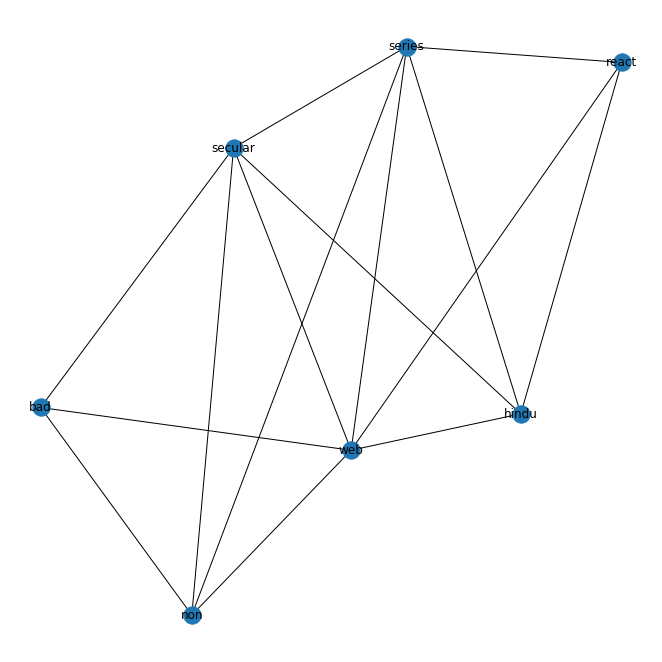

In [38]:
fig = plt.figure(figsize=(9,9))
pos = nx.spring_layout(lemma_graph)

nx.draw(lemma_graph, pos=pos, with_labels=False, font_weight="bold")
nx.draw_networkx_labels(lemma_graph, pos, labels)
plt.show()

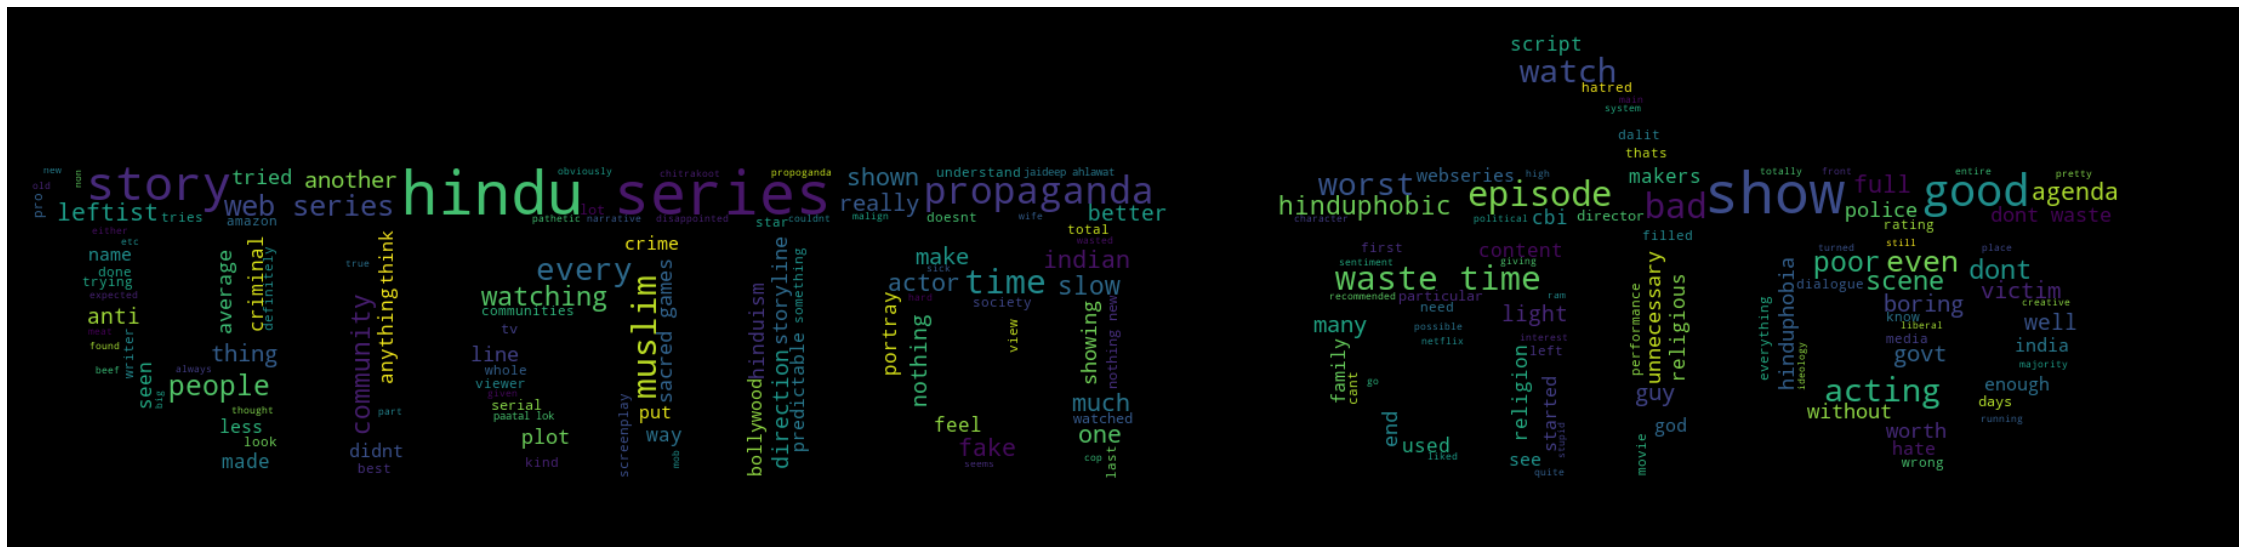

In [39]:
img = Image.open('pl-1.jpg')
custom_mask = np.array(img)
review_title_rating_1 = [words.lower() for words in df['Cleaned Text'][df['Rating'] == 1] if words not in spacy.lang.en.stop_words.STOP_WORDS]
wc = WordCloud(background_color="black",   max_font_size= 400, contour_width=0, contour_color='firebrick', mask = custom_mask)
wc.generate(','.join(review_title_rating_1))
plt.figure(figsize=(40,20))
image_colors = ImageColorGenerator(custom_mask)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

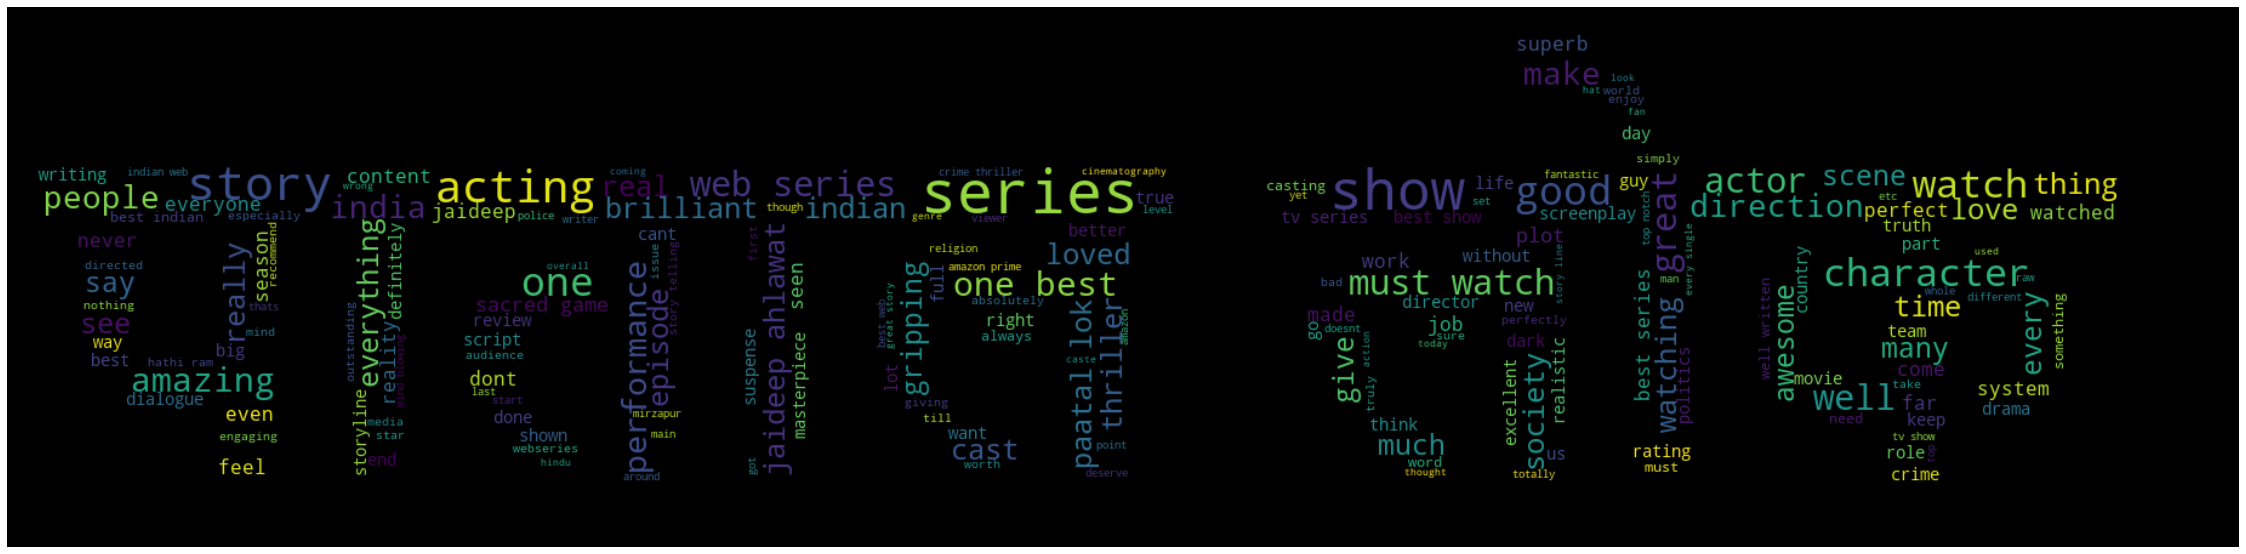

In [81]:
img = Image.open('pl-1.jpg')
custom_mask = np.array(img)
review_title_rating_1 = [words.lower() for words in df['Cleaned Text'][df['Rating'] == 10] if words not in spacy.lang.en.stop_words.STOP_WORDS]
wc = WordCloud(background_color="black",   max_font_size= 400, contour_width=0, contour_color='firebrick', mask = custom_mask)
wc.generate(','.join(review_title_rating_1))
plt.figure(figsize=(40,20))
image_colors = ImageColorGenerator(custom_mask)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

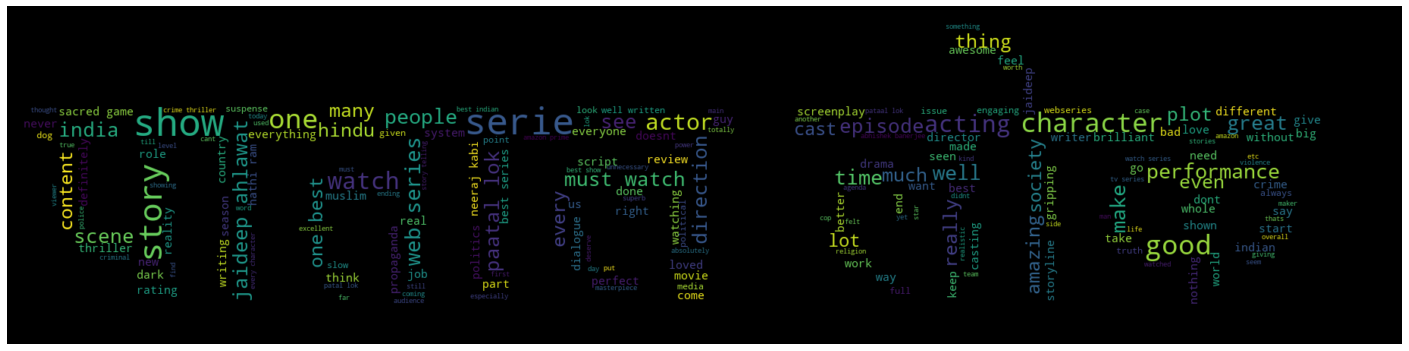

In [40]:
img = Image.open('pl-1.jpg')
custom_mask = np.array(img)
review_title_rating_1 = [words.lower() for words in df['Cleaned Text'] if words not in spacy.lang.en.stop_words.STOP_WORDS]
wc = WordCloud(background_color="black",   max_font_size= 400, contour_width=0, contour_color='firebrick', mask = custom_mask)
wc.generate(','.join(review_title_rating_1))
plt.figure(figsize=(25,10))
image_colors = ImageColorGenerator(custom_mask)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Topic Modeling Of Review**

## Named Entity Recognition
Named Entity Recognition is an information extraction task where named entities in unstructured sentences are located and classified in some pre-defined categories such as the person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc

In [41]:
for i in df['Review Text'][df['Rating'] == 1].head(3):
    spacy.displacy.render(nlp(i), style='ent',jupyter=True)

In [42]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [43]:
for j in df['Review Text'][df['Rating'] == 1].head(3):
    review = str(" ".join([i.lemma_ for i in nlp(j)]))
    doc = nlp(review)
    spacy.displacy.render(doc, style='ent',jupyter=True)

## Parts of Speech tagging
This is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech,[1] based on both its definition and its context—i.e., its relationship with adjacent and related words in a phrase, sentence, or paragraph. A simplified form of this is commonly taught to school-age children, in the identification of words as nouns, verbs, adjectives, adverbs, etc.

In [44]:
# POS tagging
for i in nlp(df['Review Text'][1]):
    print(i,"=>",i.pos_)

This => DET
movie => NOUN
revolves => VERB
around => ADP
a => DET
inspector => NOUN
who => PRON
is => AUX
solving => VERB
case => NOUN
and => CCONJ
our => PRON
system => NOUN
which => PRON
is => AUX
rotten => ADJ
is => AUX
real => ADJ
and => CCONJ
reel => NOUN
life => NOUN
both => DET
. => PUNCT
Alhawat => PROPN
ji => PROPN
acting => VERB
was => AUX
superb => ADJ
and => CCONJ
his => PRON
Haryanvi => PROPN
accent => NOUN
and => CCONJ
style => NOUN
, => PUNCT
look => VERB
Acting => NOUN
and => CCONJ
everything => PRON
was => AUX
amazing => ADJ
and => CCONJ
worth => ADJ
for => ADP
praising => VERB
He => PRON
totally => ADV
steal => VERB
the => DET
show => NOUN
the => DET
on => ADP
him => PRON
only => ADV
. => PUNCT
These => DET
types => NOUN
of => ADP
movie => NOUN
is => AUX
only => ADV
showing => VERB
how => ADV
such => ADJ
type => NOUN
of => ADP
actors => NOUN
are => AUX
brilliant => ADJ
and => CCONJ
capable => ADJ
of => ADP
doing => VERB
big => ADJ
things => NOUN
and => CCONJ
the => DE

In [45]:
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [46]:
tqdm.pandas()
df["processed_review"] = df["Review Text"].progress_apply(spacy_tokenizer)

100%|█████████████████████████████████████████████████████████████████████████████| 1149/1149 [00:02<00:00, 485.17it/s]


In [47]:
# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df["processed_review"][df['Rating'] == 10])

In [48]:
NUM_TOPICS = 5

In [49]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [50]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

In [51]:
# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [52]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]) 

In [53]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('series', 257.5438009205054), ('best', 117.91040224139599), ('watch', 109.90657431146906), ('acting', 99.26749881955556), ('good', 91.70314495280594), ('great', 82.34691224786778), ('story', 74.43841819730376), ('amazing', 70.68934169559019), ('actors', 58.293503547945875), ('web', 54.69995247899278)]
Topic 1:
[('best', 54.162316499639935), ('series', 53.121897255242594), ('people', 39.70625357110861), ('watch', 30.573906976915087), ('society', 28.139601445300997), ('like', 27.517406603457623), ('makes', 27.05086277280673), ('indian', 25.328811389047857), ('story', 24.787210307592005), ('feel', 22.51982959086523)]
Topic 2:
[('india', 20.221616442147432), ('story', 18.77607122006661), ('watch', 18.32514234764169), ('country', 16.841789687072673), ('series', 16.062912703949728), ('hindu', 15.812159023231786), ('political', 14.536168786405343), ('better', 13.771246034009637), ('bit', 13.498181192844324), ('shows', 13.099842200318315)]
Topic 3:
[('story', 22.716835579

In [54]:
# Keywords for topics clustered by Latent Semantic Indexing
print("NMF Model:")
selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('series', 5.765182856355929), ('web', 0.8886807458460884), ('indian', 0.4751627493371686), ('best', 0.4369850924007534), ('watching', 0.38436362888838976), ('good', 0.3187748612026116), ('watched', 0.2908123861000999), ('love', 0.2731805564112008), ('like', 0.2401550761356399), ('entire', 0.2389147555800355)]
Topic 1:
[('story', 2.621561310211065), ('watch', 2.320515622380252), ('acting', 1.3650117084167688), ('great', 0.9547954318383963), ('good', 0.799760291892278), ('direction', 0.5353610099274555), ('amazing', 0.4897111811395204), ('mind', 0.4496101687998215), ('jaideep', 0.429081884811539), ('characters', 0.4199882780046619)]
Topic 2:
[('like', 1.7008500014169476), ('makes', 1.514710765647818), ('society', 1.4369888614255997), ('people', 0.841494871201554), ('right', 0.6915497213508186), ('series', 0.6752295395426552), ('bad', 0.6743312101864906), ('come', 0.6272779210868981), ('movies', 0.6184348068363349), ('news', 0.6183990001107879)]
Topic 3:
[('character

In [55]:
# Keywords for topics clustered by Non-Negative Matrix Factorization
print("LSI Model:")
selected_topics(lsi, vectorizer)

LSI Model:
Topic 0:
[('series', 0.6242364566237829), ('best', 0.28149271096477474), ('story', 0.2658534069271781), ('watch', 0.20555720936856975), ('acting', 0.17571284242963509), ('like', 0.15107038675031226), ('indian', 0.13550150330964075), ('good', 0.12180193029966144), ('character', 0.11804763897093024), ('society', 0.10429399987206331)]
Topic 1:
[('story', 0.4176545510101811), ('character', 0.21424733548030836), ('acting', 0.1846943273721804), ('jaideep', 0.16624110563282804), ('hathiram', 0.13790821906357675), ('neeraj', 0.12950048775107437), ('ahlawat', 0.12682424713346965), ('journalist', 0.10668278420388057), ('role', 0.10664381720961381), ('abhishek', 0.10047578462160753)]
Topic 2:
[('like', 0.3090584357409216), ('makes', 0.3019788431303665), ('society', 0.30045663184030735), ('people', 0.16258461349595746), ('right', 0.13745712265388113), ('industry', 0.12880012612579), ('come', 0.1262696664971611), ('guess', 0.1262504751307821), ('bad', 0.12509997196789058), ('news', 0.124

In [56]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  36.093397
4       51.163364 -159.968018       2        1  29.326713
1      -73.144554   21.523815       3        1  18.212386
2      -66.410133 -110.606438       4        1   9.007331
3       54.417324   12.443444       5        1   7.360173, topic_info=    Category        Freq       Term       Total  loglift  logprob
372  Default  184.000000      story  184.000000  30.0000  30.0000
193  Default   67.000000      india   67.000000  29.0000  29.0000
107  Default   31.000000        end   31.000000  28.0000  28.0000
11   Default   66.000000    amazing   66.000000  27.0000  27.0000
224  Default   72.000000        lok   72.000000  26.0000  26.0000
..       ...         ...        ...         ...      ...      ...
429   Topic5    8.405839        web   76.824294   0.3965  -4.2581
425   Topic5   10.943542      watch  187.374142  -0.2313  -3.9943
3     Topic5    8.493531     acting  138.890842  -0.1853  -4.2478
122   Topic5    5.218447  excellent   23.150608   1.1193  -4.7349
282   Topic5    4.942643    perfect   34.892795   0.6547  -4.7892

[293 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.928659    abhishek
1         2  0.067990  absolutely
1         5  0.883873  absolutely
3         1  0.647991      acting
3         2  0.194397      acting
...     ...       ...         ...
444       5  0.059710       wrong
445       2  0.945048        year
446       1  0.431398       years
446       2  0.143799       years
446       4  0.431398       years

[519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 3, 4])